# Final Machine Learning Pipeline

In [37]:
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from feature_engine.transformation import LogTransformer
from src.utils.preprocessors import OutliersTransformer, SquareRootTransformer
from sklearn.linear_model import LogisticRegression
from src.binary_classification.classification import evaluation
from sklearn import metrics
from src.utils import utils

In [38]:
DATASET_PATH = "data/train.csv"
COLUMNS_TO_DROP = ['id', 'Unnamed: 32']
TARGET = 'diagnosis'

In [39]:
df = pd.read_csv(DATASET_PATH)
df.head(5)

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,diagnosis
0,8712291,14.97,19.76,95.50,690.2,0.08421,0.05352,0.01947,0.01939,0.1515,...,102.30,782.1,0.1045,0.09995,0.0775,0.05754,0.2646,0.06085,NaN,B
1,895633,16.26,21.88,107.50,826.8,0.11650,0.12830,0.17990,0.07981,0.1869,...,113.70,975.2,0.1426,0.21160,0.3344,0.10470,0.2736,0.07953,NaN,M
2,91813702,12.34,12.27,78.94,468.5,0.09003,0.06307,0.02958,0.02647,0.1689,...,87.22,564.9,0.1292,0.20740,0.1791,0.10700,0.3110,0.07592,NaN,B
3,8611792,19.10,26.29,129.10,1132.0,0.12150,0.17910,0.19370,0.14690,0.1634,...,141.30,1298.0,0.1392,0.28170,0.2432,0.18410,0.2311,0.09203,NaN,M
4,915664,14.81,14.70,94.66,680.7,0.08472,0.05016,0.03416,0.02541,0.1659,...,101.70,760.2,0.1139,0.10110,0.1101,0.07955,0.2334,0.06142,NaN,B


## Separating the data into train and test sets

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(COLUMNS_TO_DROP + [TARGET], axis=1), # X
    df[TARGET], # y
    test_size=0.1, # Portion of dataset to allocate to test set.
    random_state=8, # Setting the seed for reproducibility.
    stratify=df[TARGET] # Ensures proportion of samples for each class will be preserved.
)

X_train.shape, X_test.shape

((501, 30), (56, 30))

## Target

In [41]:
y_train = y_train.map({'M':1,'B':0})
y_test = y_test.map({'M':1,'B':0})

## Configuration

In [42]:
# Outliers transformer config.
THRESHOLD = 4
LIMITS = 0.1

# Scaler config.
FEATURE_RANGE = (0, 1)

# Features selected.
FEATURES = ['concavity_mean',
            'concave points_mean',
            'area_se',
            'radius_worst',
            'texture_worst',
            'perimeter_worst',
            'area_worst',
            'smoothness_worst',
            'concavity_worst',
            'concave points_worst',
            'symmetry_worst',
            'area_mean']


# Variables to square root transform.
SQUARE_ROOT_VARS = [col_name for col_name
                    in X_train.columns[(X_train == 0).any()].tolist()
                    if col_name in FEATURES]

# Variables to log transform.
LOG_TRANSFORM_VARS = [col_name for col_name in X_train.columns \
                    if not col_name in SQUARE_ROOT_VARS and col_name in FEATURES]

# Model parameters.
MODEL_PARAMS = {'penalty': 'l2',
                'C': 1000,
                'solver': 'newton-cg',
                'max_iter': 10000,
                'random_state': 42}

In [43]:
SQUARE_ROOT_VARS

['concavity_mean',
 'concave points_mean',
 'concavity_worst',
 'concave points_worst']

In [44]:
LOG_TRANSFORM_VARS

['area_mean',
 'area_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'symmetry_worst']

In [45]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

X_train.shape, X_test.shape

((501, 12), (56, 12))

## ML Pipeline

In [46]:
pipe = Pipeline([
    # Outliers.
    ('outliers_imputation', OutliersTransformer(
        variables=FEATURES,
        threshold=THRESHOLD,
        limits=LIMITS
    )),
    # Transformations.
    ('square_root', SquareRootTransformer(variables=SQUARE_ROOT_VARS)),
    ('log', LogTransformer(variables=LOG_TRANSFORM_VARS)),
    # Scaling.
    ('scaler', MinMaxScaler(feature_range=FEATURE_RANGE)),
    # Model.
    ('model', LogisticRegression(**MODEL_PARAMS)),    
])

In [47]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('outliers_imputation',
                 OutliersTransformer(limits=0.1, threshold=4,
                                     variables=['concavity_mean',
                                                'concave points_mean',
                                                'area_se', 'radius_worst',
                                                'texture_worst',
                                                'perimeter_worst', 'area_worst',
                                                'smoothness_worst',
                                                'concavity_worst',
                                                'concave points_worst',
                                                'symmetry_worst',
                                                'area_mean'])),
                ('square_root',
                 SquareRootTransformer(variables=['concavity_mean',
                                                  'concave points_mean',
                                                  'concavity_worst',
                                                  'concave points_worst'])),
                ('log',
                 LogTransformer(variables=['area_mean', 'area_se',
                                           'radius_worst', 'texture_worst',
                                           'perimeter_worst', 'area_worst',
                                           'smoothness_worst',
                                           'symmetry_worst'])),
                ('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=1000, max_iter=10000, random_state=42,
                                    solver='newton-cg'))])

### Evaluation

In [48]:
# Training set.

pred = pipe.predict(X_train)

print(evaluation(y_train, pred))

   accuracy  precision  recall     f1  auc_roc
0     0.986     0.9837  0.9784  0.981   0.9844


In [49]:
# Test set.

pred = pipe.predict(X_test)

print(evaluation(y_test, pred))

   accuracy  precision  recall      f1  auc_roc
0    0.9643     0.9524  0.9524  0.9524   0.9619


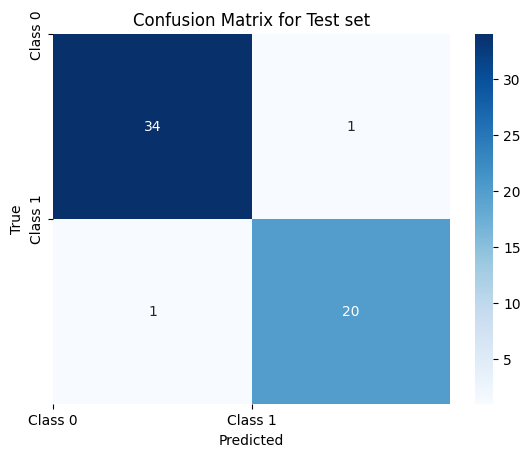

In [50]:
confusion_matrix = metrics.confusion_matrix(y_test,
                                            pred)
class_labels = ['Class 0', 'Class 1']

# Create a heatmap plot of the confusion matrix
utils.plot_confusion_matrix(confusion_matrix,
                            class_labels)

### Saving the pipeline.

In [51]:
joblib.dump(pipe, 'outputs/ML_pipe.joblib') 

['outputs/ML_pipe.joblib']